<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Forest Emissions Tracking - Validation

_CarbonPlan ClimateTrace Team_

This notebook compares our estimates of country-level forest emissions to prior
estimates from other groups. The notebook currently compares againsts:

- Global Forest Watch (Zarin et al. 2016)
- Global Carbon Project (Friedlingstein et al. 2020)


In [54]:
import geopandas
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

from carbonplan_styles.mpl import set_theme
from carbonplan_styles.colors import dark
set_theme()

In [15]:
# Input data
# ----------

# country shapes from GADM36
countries = geopandas.read_file(
    "s3://carbonplan-climatetrace/inputs/shapes/countries.shp"
)

# CarbonPlan's emissions
emissions = {}
versions = [ 'v0.3', 'v0.4'] #'v0.1',
for version in versions:
#     try:
#         emissions[version] = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups_emissions.csv".format(version))
#     except:
#         emissions[version] = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups.csv".format(version))
# #         continue

    for mechanism in ['fire', 'clearing']:
        emissions[version+'-'+mechanism] = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups_emissions_from_{}.csv".format(version, mechanism))
    emissions[version] = emissions[version+'-fire'].copy(deep=True)
    emissions[version]['tCO2eq'] = emissions[version+'-fire']['tCO2eq']+emissions[version+'-clearing']['tCO2eq']
# GFW emissions
gfw_emissions = pd.read_excel(
    "s3://carbonplan-climatetrace/validation/gfw_global_emissions.xlsx",
    sheet_name="Country co2 emissions",
).dropna(axis=0)
gfw_emissions = gfw_emissions[
    gfw_emissions["threshold"] == 10
]  # select threshold

# Global Carbon Project
gcp_emissions = (
    pd.read_excel(
        "s3://carbonplan-climatetrace/validation/Global_Carbon_Budget_2020v1.0.xlsx",
        sheet_name="Land-Use Change Emissions",
        skiprows=28,
    )
    .dropna(axis=1)
    .set_index("Year")
)
gcp_emissions *= 3.664  # C->CO2
gcp_emissions.index = [
    pd.to_datetime(f"{y}-01-01") for y in gcp_emissions.index
]
gcp_emissions = gcp_emissions[["GCB", "H&N", "BLUE", "OSCAR"]]

# Blue Sky Fire emissions
emissions['Blue Sky'] = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/forest-fires_bsa.csv")

# all the inventories
inventories_df = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/210623_all_inventory_data.csv")


In [16]:
# Merge emissions dataframes with countries GeoDataFrame
gfw_countries = countries.merge(
    gfw_emissions.rename(columns={"country": "name"}), on="name"
)
trace_countries = {}
for version in versions:
    trace_countries[version] = countries.merge(
        emissions[version].rename(columns={"iso3_country": "alpha3"}), on="alpha3"
    )
    for mechanism in ['fire', 'clearing']:
        trace_countries[version+'-'+mechanism] = countries.merge(
            emissions[version+'-'+mechanism].rename(columns={"iso3_country": "alpha3"}), on="alpha3"
        )

In [5]:
for mechanism in ['fire', 'clearing']:
    for version in ['v0.3', 'v0.4']:
        df = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups_emissions_from_{}.csv".format(version, mechanism))
        us_emissions = df[df['iso3_country']=='USA'][df['begin_date']=='2015-01-01']['tCO2eq'].values
        print('US - 2015 - {} - {} - {} Gt'.format(mechanism, version, us_emissions))

/tmp/ipykernel_67/3859830404.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  us_emissions = df[df['iso3_country']=='USA'][df['begin_date']=='2015-01-01']['tCO2eq'].values


US - 2015 - fire - v0.3 - [0.15196833] Gt
US - 2015 - fire - v0.4 - [0.10664691] Gt
US - 2015 - clearing - v0.3 - [0.52205376] Gt
US - 2015 - clearing - v0.4 - [0.47170273] Gt


In [17]:
# reformat to "wide" format (time x country)
trace_wide = {}
for version in emissions.keys():
    if version != 'Blue Sky':
        trace_wide[version] = (
            emissions[version].drop(columns=["end_date"])
            .pivot(index="begin_date", columns="iso3_country")
            .droplevel(0, axis=1)
        )
        trace_wide[version].index = pd.to_datetime(trace_wide[version].index)
gfw_wide = (
    gfw_emissions.set_index("country")
    .filter(regex="whrc_aboveground_co2_emissions_Mg_.*")
    .T
)
gfw_wide.index = [pd.to_datetime(f"{l[-4:]}-01-01") for l in gfw_wide.index]

gfw_wide.head()

country,Angola,Anguilla,Antigua and Barbuda,Aruba,Bahamas,Bangladesh,Barbados,Belize,Benin,Bhutan,...,Timor-Leste,Togo,Trinidad and Tobago,Turks and Caicos Islands,Uganda,Venezuela,Vietnam,"Virgin Islands, U.S.",Zambia,Zimbabwe
2001-01-01,31136879.0,538.0,5376.0,0.0,62247.0,1926681.0,2948.0,2664263.0,2595676.0,140861.0,...,307218.0,1019587.0,641304.0,1059.0,10925954.0,37489138.0,18637306.0,33872.0,11120464.0,3341102.0
2002-01-01,16829411.0,22.0,3893.0,85.0,112943.0,1589109.0,2873.0,4076547.0,2780439.0,107165.0,...,704508.0,819767.0,253466.0,674.0,3159491.0,26071313.0,18995849.0,6316.0,15524726.0,3497928.0
2003-01-01,13910080.0,190.0,4064.0,156.0,41118.0,848477.0,794.0,2218989.0,4134499.0,227076.0,...,312124.0,948716.0,255138.0,1140.0,4203655.0,27666280.0,16483340.0,11361.0,15746559.0,3571212.0
2004-01-01,18427670.0,1327.0,6235.0,0.0,89321.0,1635774.0,2295.0,1320572.0,522435.0,497910.0,...,870732.0,1152064.0,276882.0,1325.0,5912218.0,27342980.0,28882631.0,10498.0,10901084.0,4330461.0
2005-01-01,23622906.0,571.0,16365.0,0.0,213287.0,1334780.0,2226.0,2578664.0,4509795.0,391291.0,...,565295.0,1276745.0,429870.0,2475.0,9948475.0,28190210.0,39344380.0,5310.0,22127861.0,5612324.0


## Part 1 - Compare time-averaged country emissions (tropics only)


In [18]:
# Create a new dataframe with average emissions
avg_emissions = countries.set_index("alpha3")
for version in trace_wide.keys():
    avg_emissions[version] = trace_wide[version].mean().transpose()
avg_emissions = avg_emissions.set_index("name")
avg_emissions["gfw"] = gfw_wide.mean().transpose() / 1e9

In [19]:
avg_emissions['diff_fire'] = avg_emissions['v0.3-fire'] - avg_emissions['v0.4-fire']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


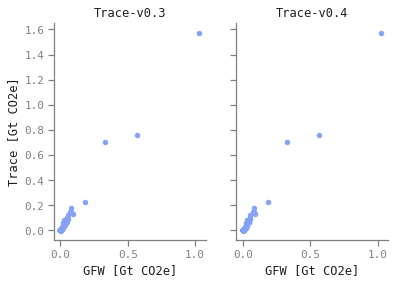

In [20]:
# Scatter Plot
fig, axarr = plt.subplots(ncols=2, sharey=True)
for i, version in enumerate(versions):
    avg_emissions.plot.scatter("gfw", version, ax=axarr[i])
    axarr[i].set_ylabel("Trace [Gt CO2e]")
    axarr[i].set_xlabel("GFW [Gt CO2e]")
    axarr[i].set_title("Trace-{}".format(version))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


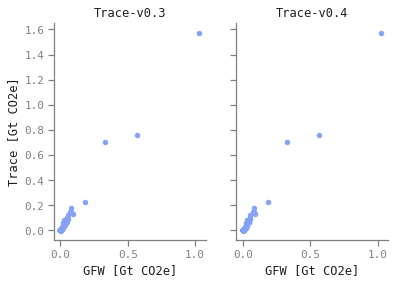

In [21]:
# Scatter Plot
fig, axarr = plt.subplots(ncols=2, sharey=True)
for i, version in enumerate(versions):
    avg_emissions.plot.scatter("gfw", version, ax=axarr[i])
    axarr[i].set_ylabel("Trace [Gt CO2e]")
    axarr[i].set_xlabel("GFW [Gt CO2e]")
    axarr[i].set_title("Trace-{}".format(version))

## Part 2 - Maps of Tropical Emissions


In [22]:
avg_emissions_nonan = avg_emissions.dropna()

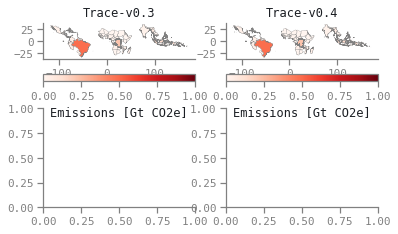

In [23]:
fig, axarr = plt.subplots(nrows=2, ncols=2)
for i, version in enumerate(versions):
    kwargs = dict(
        legend=True,
        legend_kwds={"orientation": "horizontal", "label": "Emissions [Gt CO2e]"},
        lw=0.25,
        cmap="Reds",
        vmin=0,
        vmax=1,
        ax=axarr[0,i]
    )
    avg_emissions_nonan.plot("{}-fire".format(version), **kwargs)
    axarr[0,i].set_title("Trace-{}".format(version))


/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


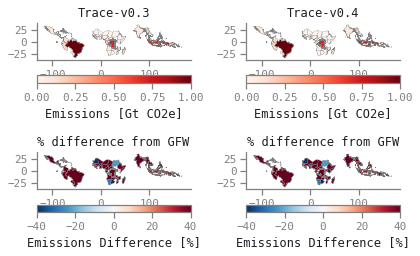

In [28]:
fig, axarr = plt.subplots(nrows=2, ncols=2)
for i, version in enumerate(versions):
    kwargs = dict(
        legend=True,
        legend_kwds={"orientation": "horizontal", "label": "Emissions [Gt CO2e]"},
        lw=0.25,
        cmap="Reds",
        vmin=0,
        vmax=1,
        ax=axarr[0,i]
    )
    avg_emissions_nonan.plot("{}".format(version), **kwargs)
    axarr[0,i].set_title("Trace-{}".format(version))

for i, version in enumerate(versions):
    kwargs = dict(
    legend=True,
    legend_kwds={
        "orientation": "horizontal",
        "label": "Emissions Difference [%]",
    },
    lw=0.25,
    cmap="RdBu_r",
    vmin=-40,
    vmax=40,
    ax=axarr[1,i]
)
    avg_emissions_nonan["pdiff"] = (
        (avg_emissions_nonan["{}".format(version)] - avg_emissions_nonan["gfw"])
        / avg_emissions_nonan["gfw"]
    ) * 100
    avg_emissions_nonan.plot("pdiff", **kwargs)
    axarr[1,i].set_title("% difference from GFW")
    
plt.tight_layout()

In [29]:
kwargs = dict(
        legend=True,
        legend_kwds={"orientation": "horizontal", "label": "Emissions [Gt CO2e]"},
        lw=0.25,
        cmap="Reds",
        vmin=0,
        vmax=1,
        ax=axarr[0,i]
    )
avg_emissions_nonan.plot("gfw" **kwargs)

plt.title("GFW Tropics")

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'dict'

## Part 3 - Compare trace_wideglobal emissions timeseries to Global Carbon Project


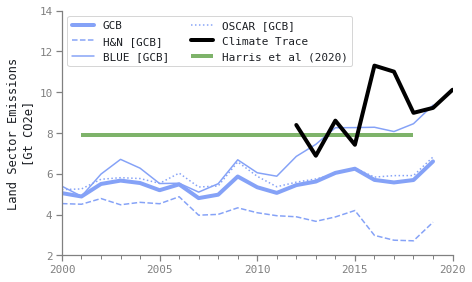

In [79]:
plt.figure(figsize=(7,4.5))
ax = gcp_emissions["GCB"].loc["2000":].plot(label="GCB", lw=4, color=dark['blue'])
for dataset, line_style in zip(["H&N", "BLUE", "OSCAR"], ['--', '-', ':']):
    gcp_emissions[dataset].loc["2000":].plot(label=dataset+' [GCB]', ls=line_style, color=dark['blue'])
# trace_wide['v0.1'].sum(axis=1).plot(ax=ax, label="Trace v0.1".format(version), c="k", lw=3)
trace_wide['v0.3'].sum(axis=1).plot(ax=ax, label="Climate Trace".format(version), c="k", ls='-', lw=4)
ax.hlines(7.9, xmin='2001', xmax='2018', label='Harris et al (2020)', color=dark['green'], lw=4)
plt.ylabel("Land Sector Emissions\n[Gt CO2e]")
plt.xlabel('')
plt.legend(ncol=2)
plt.ylim(2,14)
plt.savefig('global_comparisons.png')


## Part 4 - Compare fire emissions from CarbonPlan with those from Blue Sky

In [31]:
bsa = pd.read_csv('global-CO2-estimates-per-vegetation-2015-2020-BSA.csv')

In [32]:
opencanopy = bsa[bsa['parent_class']=='open_canopy_forest'].drop('parent_class', axis=1)

closedcanopy = bsa[bsa['parent_class']=='closed_canopy_forest'].drop('parent_class', axis=1)

merged = pd.merge(opencanopy.rename({'tCO2': 'open_canopy'}, axis=1), 
         closedcanopy.rename({'tCO2': 'closed_canopy'}, axis=1),
         how='left', left_on=['iso3_country','begin_date'],
         right_on=['iso3_country','begin_date'])

In [33]:
merged['total'] = merged['open_canopy'] + merged['closed_canopy']

bsa_comparisons = pd.merge(emissions['Blue Sky'].rename({'tCO2': 'website'}, axis=1),
                           merged.rename({'total': 'slack'}, axis=1),
                           how='left', left_on=['iso3_country','begin_date'],
         right_on=['iso3_country','begin_date'])

In [34]:
bsa_comparisons[bsa_comparisons['iso3_country']=='COD']

,website,iso3_country,begin_date,end_date,open_canopy,end_date_x,closed_canopy,end_date_y,slack
49,6.922832e+08,COD,2015-01-01,2016-01-01,1.211562e+08,2016-01-01,4.968389e+08,2016-01-01,6.179951e+08
256,7.486633e+08,COD,2016-01-01,2017-01-01,1.215563e+08,2017-01-01,5.561352e+08,2017-01-01,6.776915e+08
465,6.773686e+08,COD,2017-01-01,2018-01-01,1.159877e+08,2018-01-01,4.925143e+08,2018-01-01,6.085021e+08
674,6.781723e+08,COD,2018-01-01,2019-01-01,1.143420e+08,2019-01-01,4.966938e+08,2019-01-01,6.110357e+08
881,6.675174e+08,COD,2019-01-01,2020-01-01,1.085527e+08,2020-01-01,4.895868e+08,2020-01-01,5.981395e+08
1088,7.217670e+08,COD,2020-01-01,2021-01-01,1.134957e+08,2021-01-01,5.505704e+08,2021-01-01,6.640661e+08


In [35]:
comparison = pd.merge(emissions['v0.3-fire'].rename({'tCO2eq': 'CarbonPlan'}, axis=1), 
                      emissions['Blue Sky'].rename({'tCO2': 'Blue Sky'}, axis=1),  how='left', left_on=['iso3_country','begin_date'], 
                      right_on = ['iso3_country','begin_date'])

In [36]:
comparison = comparison.drop(['end_date_x', 'end_date_y'], axis=1)
comparison['Blue Sky'] /= 1e9

In [37]:
for dataset in ['CarbonPlan', 'Blue Sky']:
    comparison = comparison.rename({dataset: dataset+' [GtCO2/year]'}, axis=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


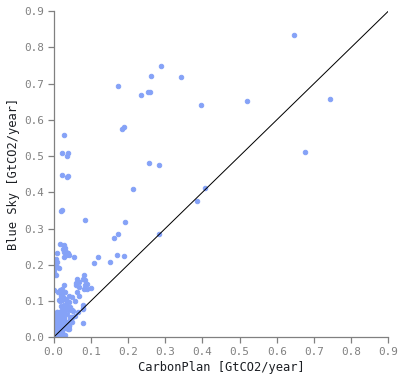

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
comparison.plot.scatter('CarbonPlan [GtCO2/year]', 'Blue Sky [GtCO2/year]', ax=ax)
ax.set_xlim(0,0.9)
ax.set_ylim(0,0.9)
plt.plot([0,1], [0,1], 'k-', lw=1)

In [39]:
## Part 5 - Compare emissions from CarbonPlan with other inventories

In [40]:
inventories_df = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/210623_all_inventory_data.csv")


In [9]:
set(inventories_df['Data source'].values)

{'CAIT',
 'ClimateTRACE',
 'EDGAR',
 'GCP',
 'PIK-CR',
 'PIK-TP',
 'carbon monitor',
 'unfccc',
 'unfccc_nai'}

In [82]:
def select_inventory_timeseries(df, inventory=None, country=None, sector=None):
    if inventory is not None:
        df = df[df['Data source']==inventory]
    if country is not None:
        df = df[df['Country'] == country]
    if sector is not None:
        df= df[df['Sector'] == sector]
    return df

In [86]:
select_inventory_timeseries(inventories_df, country='Brazil', inventory='CAIT', sector='Land-Use Change and Forestry')[[str(year) for year in range(2000, 2019)]]

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
31,1041.43,1105.43,1112.14,1110.98,1112.4,1115.42,1107.64,1118.24,1106.46,1103.36,1118.17,265.75,269.54,264.18,266.89,271.59,392.29,396.51,387.94
